# Classification of Associated Place Reinstatement

#### fMRI preprocessing:

```
##############################################
# Register timeseries for MVPA analyses
##############################################

sub_list=subjects.txt
exp=mvpa_raw
 
run_fmri.py -s $sub_list -e $exp -w preproc reg -t -regspace epi -unsmoothed
```

In [1]:
%matplotlib inline

In [2]:
import glob
import os.path as op
import os as os
import nibabel as nib
import pandas as pd
import numpy as np
import scipy as sp

from nilearn.masking import compute_epi_mask

import matplotlib.pyplot as plt
import matplotlib as mpl

# Nilearn for neuro-imaging-specific machine learning
from nilearn.input_data import NiftiMasker
from nilearn import image

# Nibabel for general neuro-imaging tools
import nibabel

# Scikit-learn for machine learning
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score
from sklearn import preprocessing

# Plotting
import matplotlib.pyplot as plt
from nilearn import plotting
import seaborn as sns
sns.set(context="poster", style="ticks", font="Arial")


/Users/sgagnon/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
palette = {'logreg': 'mediumseagreen',
           'chance': 'darkgray',
           'f1 score': 'teal'}

### Define some functions for classification 

In [4]:
from ap_classify import *

v6


### Define function to train on localizer, calculate probabilities w/test data

## Set up directory & file information

In [5]:
smoothing = 'unsmoothed'
regspace = 'epi'
loc_design = 'localizer_cond_mvpa.csv'
mem_design = 'AP_memory_itemhits_byrep.csv' 
# mem_design = 'AP_memory_itemhits.csv' 
smoothing_fwhm = 0
standardize = True
multi_class_alg = 'ovr'
tr = float(2)
tr_shift = 4.5 #4.5 seconds post-stim onset
tr_shift_test_list = [0, 2, 4, 6, 8, 10, 12] # seconds to shift onset forward by
# tr_shift_test_list = [4, 6]

basedir = '/Volumes/group/awagner/sgagnon/AP'
analydir = op.join(basedir, 'analysis/mvpa_raw')
subjfile = op.join(analydir, 'notebooks/subj_info.csv')
subj_info = pd.read_csv(subjfile)

# Filepath templates
tsfile = op.join(analydir, "{subid}", 'reg', regspace, 
                 smoothing, "run_{run_id}", 'timeseries_xfm.nii.gz')
func_maskfile = op.join(analydir, "{subid}", 'reg', regspace, 
                        smoothing, "run_{run_id}", 'functional_mask_xfm.nii.gz')
maskfile = op.join(basedir, 'data', "{subid}", 'masks', 
                   "{mask_name}.nii.gz")
# meanfile = op.join(analydir, "{subid}", 'reg', regspace, 
#                    smoothing, "run_{run_id}", 'mean_func_xfm.nii.gz')
meanfile = op.join(analydir, "{subid}", 'preproc',
                   "run_{run_id}", 'mean_func.nii.gz')
loc_onsetfile = op.join(basedir, 'data', "{subid}", 'design', loc_design)
mem_onsetfile = op.join(basedir, 'data', "{subid}", 'design', mem_design)


# Output templates
outnifti = op.join(analydir, "{subid}", 'importance_maps')
# outtrials = op.join(analydir, "{subid}", 'trial_estimates', 
# '{subid}_{output}_{time}s_trial_{multi_class_alg}_estimates_3class_{mask}_byrep_filtartloc_scalewithinrun.csv')
outtrials = op.join(analydir, "{subid}", 'trial_estimates', 
                    '{subid}_{output}_{time}s_trial_{multi_class_alg}_estimates_3class_{mask}_byrep_filtartloc_equalizecounts.csv')

artifacts = op.join(analydir, '{subid}', 'preproc', 'run_{run}', 'artifacts.csv')

# Combine paths into dictionary (facilitate passing i/o of funcs)
paths = dict(tsfile=tsfile, func_maskfile=func_maskfile, 
             maskfile=maskfile, meanfile=meanfile, 
             loc_onsetfile=loc_onsetfile, mem_onsetfile=mem_onsetfile, 
             outnifti=outnifti, outtrials=outtrials, analydir=analydir, artifacts=artifacts)

## Run Classification

In [6]:
subj_info.groupby('group').count()

,subid
group,
control,22
stress,22


In [7]:
pd.read_csv(mem_onsetfile.format(subid='ap100')).condition.unique()

array(['sourcemiss_hi-4', 'CR-0', 'sourcehit-2', 'sourcehit-4', 'M-4',
       'M-2', 'FA-0', 'itemhit_lo-2', 'sourcemiss_hi-2', 'itemhit_lo-4',
       'nuisance-2', 'nuisance'], dtype=object)

In [8]:
# Initialize some stuff
mask_type = 'mask' # functional mask, or defined elsewhere
mask_name = 'bilat-parahipp_fusi_inftemp_nohipp'

# Localizer and memory data info
loc_run_list = [7,8]
mem_run_list = range(1,7)

loc_cond_list = ['face', 'object', 'place']
mem_cond_list = ['sourcemiss_hi-4', 'CR-0', 'sourcehit-2', 'sourcehit-4', 'M-4',
                 'M-2', 'FA-0', 'itemhit_lo-2', 'sourcemiss_hi-2', 'itemhit_lo-4']

### Extract data (focus on 6s post-stim onset, ie peak)

In [32]:
d = pd.DataFrame(columns=['subid', 'sh_count', 'sh_2dsd'])

for subid in subj_info.subid: 


    print subid + '-----------------------------------------------'

    if subid == 'ap155':
        mem_run_list = range(1,6)
    else:
        mem_run_list = range(1,7)

    X, run_labels, ev_labels, ev_trs, ev_onsets, func_masker = get_subj_data(subid, mem_onsetfile, mem_cond_list, paths, mask_type, mask_name,
                                                                             smoothing_fwhm, standardize, tr, 6, mem_run_list, 
                                                                             shift_rest=False, filter_artifacts=True)
    # count of SHs
    sh_ind = np.array(pd.Series(ev_labels).isin(['sourcehit-4', 'sourcehit-2']))
    X_sh = X[sh_ind]
    print X_sh.shape
    
    row = {'subid': subid, 
           'sh_count': X_sh.shape[0],
           'sh_2dsd': calc_2d_stdev(X_sh)}

    d = d.append(pd.DataFrame.from_dict({0: row}, orient='index'))

ap100-----------------------------------------------
Number of voxels: 2089
Loading data from run 1 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (41,)
Orig TRs: 221
X shape: (41, 2089)
Loading data from run 2 ...
Removing 0 TRs with artifacts...
scaling the data...
# Events: (83,)
Orig TRs: 221
X shape: (83, 2089)
Loading data from run 3 ...
Removing 2 TRs with artifacts...
scaling the data...
# Events: (109,)
Orig TRs: 221
X shape: (109, 2089)
Loading data from run 4 ...
scaling the data...
# Events: (151,)
Orig TRs: 221
X shape: (151, 2089)
Loading data from run 5 ...
Removing 3 TRs with artifacts...
scaling the data...
# Events: (190,)
Orig TRs: 221
X shape: (190, 2089)
Loading data from run 6 ...
scaling the data...
# Events: (232,)
Orig TRs: 221
X shape: (232, 2089)
(88, 2089)
ap101-----------------------------------------------
Number of voxels: 2081
Loading data from run 1 ...
scaling the data...
# Events: (42,)
Orig TRs: 221
X shape: (42, 2081)
Loading dat

In [33]:
d.shape

(44, 3)

In [35]:
d = d.merge(subj_info)
d.head()

,subid,sh_count,sh_2dsd,group
0,ap100,88,45.111442,control
1,ap101,102,45.318215,control
2,ap102,66,48.410503,control
3,ap103,113,42.474585,control
4,ap104,146,44.873125,control


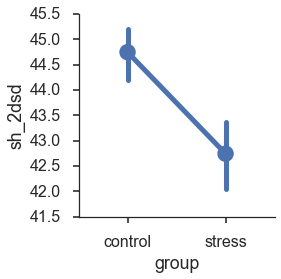

In [38]:
sns.factorplot(x='group', y='sh_2dsd', data=d, ci=68)

In [39]:
d.to_csv('/Volumes/group/awagner/sgagnon/AP/results/retrieval_2dsd_SH_bilat-parahipp_fusi_inftemp_nohipp.csv')